# Perceptrons

## Load Libraries and Data

In [1]:
import io
import requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             precision_recall_curve,
                             PrecisionRecallDisplay,
                             roc_auc_score, RocCurveDisplay)
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)

# Options for plots
%matplotlib inline
sns.set()
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 12

In [2]:
# Load NLSY data
url = 'https://raw.githubusercontent.com/natecraig/aiml/main/Data/nlsy.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,ID,Earnings,WeeksWorked,CumWeeksWorked,Education,IQ,Gender,MSA,Library,Esteem
0,83,0,3,553.0,10,2,Male,Yes,Yes,18
1,84,0,3,107.0,12,9,Male,Yes,Yes,20
2,87,11500,5,759.0,12,5,Male,Yes,Yes,22
3,105,20501,11,979.0,12,84,Female,Yes,Yes,19
4,178,59000,46,1010.0,16,99,Male,No,Yes,24


In [3]:
# Return indicator of education category as a function of years of education
def higher_ed_category(years_education):
    if years_education >= 16:
        return 1
    else:
        return 0
    
# Create a variable to contain each participant's education category    
df['HigherEdCategory'] = df['Education'].apply(higher_ed_category)
df['HigherEdCategory'].value_counts(normalize=True)

0    0.830679
1    0.169321
Name: HigherEdCategory, dtype: float64

In [4]:
X = df[['Earnings', 'WeeksWorked', 'CumWeeksWorked']]
y = df['HigherEdCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     random_state=random_state)

## Fit a Perceptron Model

In [5]:
per_clf = Perceptron(class_weight='balanced', random_state=random_state)
per_clf.fit(X_train, y_train)

# Evaluate on test data
y_pred = per_clf.predict(X_test)
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}\n'
      f'Precision: {precision_score(y_test, y_pred):.3f}\n'
      f'Recall:    {recall_score(y_test, y_pred):.3f}\n'
      f'F1:        {f1_score(y_test, y_pred):.3f}')

Accuracy:  0.926
Precision: 0.886
Recall:    0.696
F1:        0.780


In [6]:
# Show the weights of the perceptron
coef = per_clf.coef_[0]
coef

array([   34692.15757089,   -89207.61579738, -1753622.96253029])

In [7]:
# Show the bias term of the perceptron
intercept = per_clf.intercept_
intercept

array([-2120.48305985])

In [8]:
# Calculate input to the activation function (the step function) manually
X_new = pd.DataFrame({
    'Earnings':[20000],
    'WeeksWorked':[52],
    'CumWeeksWorked':[800]
})

(intercept + (coef[0] * X_new['Earnings'][0])
 + (coef[1] * X_new['WeeksWorked'][0])
 + (coef[2] * X_new['CumWeeksWorked'][0]))

array([-7.13696135e+08])

In [9]:
# Calculate input to the activation function via scikit-learn
per_clf.decision_function(X_new)

array([-7.13696135e+08])

In [10]:
# The input to the activation function is negative, so the
# perceptron will predict class 0
per_clf.predict(X_new)

array([0])

### Exercise

Try fitting a perceptron model without the "balanced" class weight argument. What does the model predict and why?

## Precision-Recall Trade-off and ROC

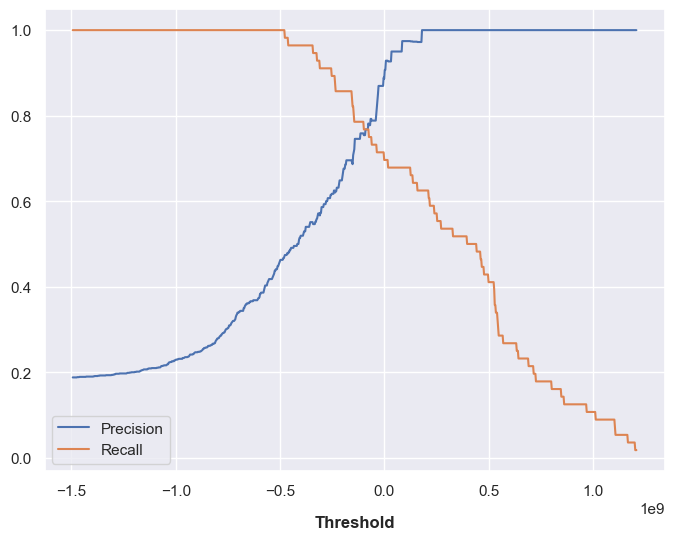

In [11]:
# Manually create a precision-recall curve plot
y_score = per_clf.decision_function(X_test)
thresholds = np.linspace(min(y_score), max(y_score) - 1, num=1000)

precisions = []
recalls = []
for t in thresholds:
    y_pred = (y_score > t)
    precisions += [precision_score(y_test, y_pred)]
    recalls += [recall_score(y_test, y_pred)]

plt.subplots(figsize=(8, 6))
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.xlabel('Threshold')
plt.legend(['Precision', 'Recall'])

# plt.savefig('Precision-Recall Threshold.png')
plt.show()

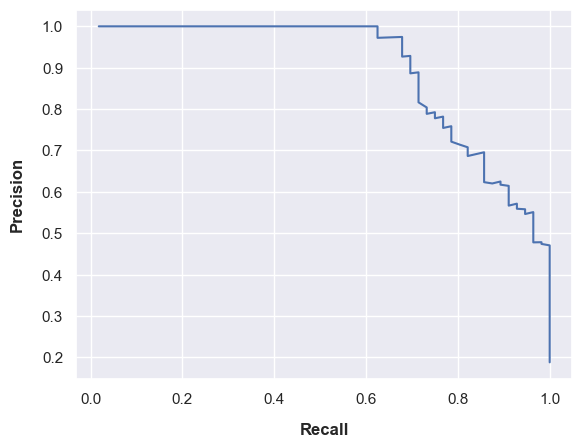

In [12]:
# Plot precision against recall
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

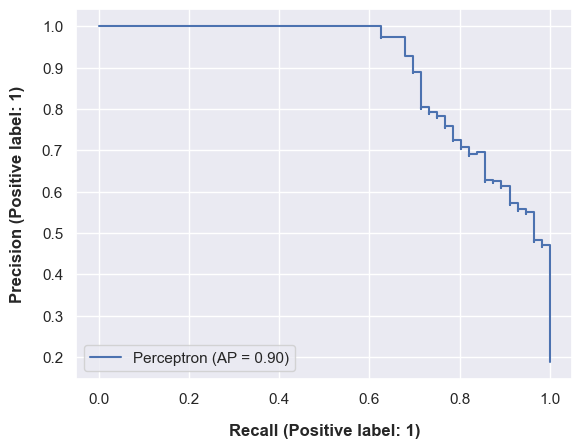

In [13]:
# Visualization of the precision-recall relationship using scikit-learn
PrecisionRecallDisplay.from_estimator(per_clf, X_test, y_test)
# plt.savefig('Precision-Recall.png')
plt.show()

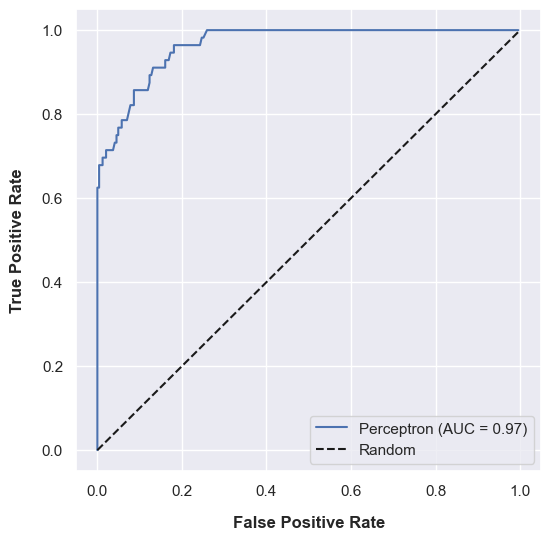

In [14]:
# Manually plot the Receiver Operating Characteristic (ROC) curve
y_score = per_clf.decision_function(X_test)
thresholds = np.linspace(min(y_score), max(y_score), num=1000)

pos = sum(y_test)
neg = sum(1 - y_test)

true_pos_rates = []
false_pos_rates = []
for t in thresholds:
    y_pred = (y_score > t).astype(int)
    
    true_pos = ((y_test == 1) & (y_pred == y_test)).sum()
    false_pos = ((y_pred == 1) & (y_pred != y_test)).sum()

    true_pos_rates += [true_pos / pos]
    false_pos_rates += [false_pos / neg]

plt.subplots(figsize=(6, 6))
plt.plot(false_pos_rates, true_pos_rates)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'Perceptron (AUC = {roc_auc_score(y_test, y_score):0.2f})',
            'Random'])

# plt.savefig('ROC Curve.png')
plt.show()    

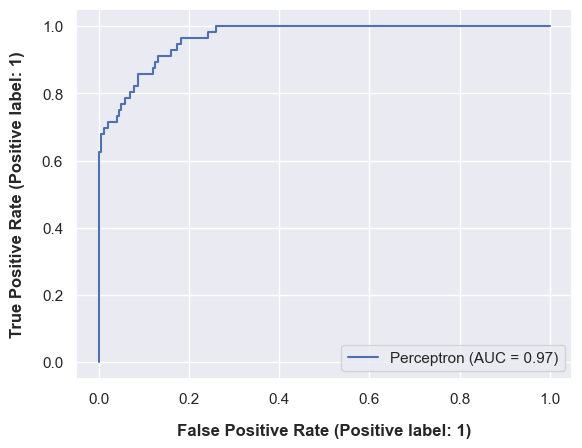

In [15]:
# Visualize ROC curve using scikit-learn
RocCurveDisplay.from_estimator(per_clf, X_test, y_test)
plt.show()

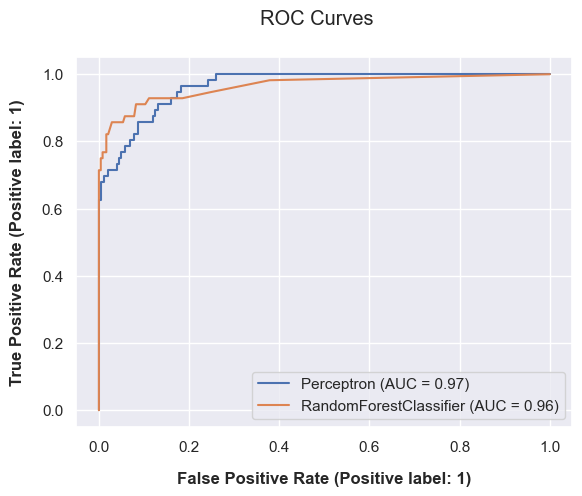

In [16]:
# Compare the perceptron to a random forest
rnd_clf = RandomForestClassifier(random_state=random_state)
rnd_clf.fit(X_train, y_train)

per_disp = RocCurveDisplay.from_estimator(per_clf, X_test, y_test)
rnd_disp = RocCurveDisplay.from_estimator(rnd_clf, X_test, y_test,
                                          ax=per_disp.ax_)
rnd_disp.figure_.suptitle('ROC Curves')

# plt.savefig('ROC Curve Comparison.png')
plt.show()

### Exercise

Read through the code that manually plots the precision-recall and ROC curves to make sure you understand the construction and meaning of the plots.